### 앙상블 모델
성능이 가장 나았던 버전으로 모델들 가져와서 하드보팅

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# 데이터 임포트
import os
import pandas as pd

os.chdir("/content/drive/MyDrive/open")

train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')

In [ ]:
# 모듈 임포트
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") 

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

In [ ]:
# ID 떼기 (한 번만 실행!)
train_df = train_df.iloc[:, 1:]
val_df = val_df.iloc[:, 1:]

In [ ]:
train_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972
1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972
2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.256131,-0.994960
3,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0.262698,-0.994901
4,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.994900,-0.994901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113837,-12.516732,10.187818,-8.476671,-2.510473,-4.586669,-1.394465,-3.632516,5.498583,4.893089,8.655320,...,-0.944759,-1.565026,0.890675,-1.253276,1.786717,0.320763,2.090712,1.232864,-0.169496,1.034857
113838,1.884849,-0.143540,-0.999943,1.506772,-0.035300,-0.613638,0.190241,-0.249058,0.666458,0.120908,...,0.144008,0.634646,-0.042114,-0.053206,0.316403,-0.461441,0.018265,-0.041068,0.530986,1.034881
113839,-0.241923,0.712247,0.399806,-0.463406,0.244531,-1.343668,0.929369,-0.206210,0.106234,-0.284708,...,-0.228876,-0.514376,0.279598,0.371441,-0.559238,0.113144,0.131507,0.081265,-0.230699,1.034904
113840,0.120316,0.931005,-0.546012,-0.745097,1.130314,-0.235973,0.812722,0.115093,-0.204064,-0.657422,...,-0.314205,-0.808520,0.050343,0.102800,-0.435870,0.124079,0.217940,0.068803,-0.269825,1.034939


In [ ]:
# val 데이터에서 사기 거래 비율 추론
val_normal, val_fraud = val_df['Class'].value_counts()
contamination_ratio = val_fraud / val_normal
contamination_ratio

0.0010551491277433877

### EE + minmax + feature selection

In [ ]:
val_df_X = val_df.drop(['Class'], axis=1)

In [ ]:
# feature selection
selected_feature = [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18, 21, 27, 30]
feature_num = [selected_feature[i] - 1 for i in range(len(selected_feature))]

train_df_2 = train_df.iloc[:, feature_num]
val_df_X_2 = val_df_X.iloc[:, feature_num]

In [ ]:
# 정규화
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()

train_df_2_scaled = minmax_scaler.fit_transform(train_df_2)
val_df_X_2_scaled = minmax_scaler.transform(val_df_X_2)

In [ ]:
# 객체 생성
EE = EllipticEnvelope(contamination=contamination_ratio)

In [ ]:
EE.fit(train_df_2_scaled)

EllipticEnvelope(contamination=0.0010551491277433877)

In [ ]:
# 예측
y_pred_EE = EE.predict(val_df_X_2_scaled)
y_pred_EE = np.where(y_pred_EE == -1, 1, 0)

# # 평가
# val_score_2 = f1_score(y_val, y_pred_EE, average='macro')
# print(f'Validation F1 Score (feature selection) : [{val_score_2}]')

### IF + Robust + feature selection

In [ ]:
def get_pred_label(model_pred):
    # IsolationForest 모델 출력 (1:정상, -1:불량(사기)) 이므로 (0:정상, 1:불량(사기))로 Label 변환
    #예측된 모든 정상 샘플(격리 포레스트 모델에서 1로 레이블 지정)을 0으로 대체
    model_pred = np.where(model_pred == 1, 0, model_pred)

    #예측된 모든 이상 샘플(격리 포레스트 모델에 의해 -1로 레이블 지정됨)을 1로 대체
    model_pred = np.where(model_pred == -1, 1, model_pred)
    return model_pred

In [ ]:
train_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972
1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972
2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.256131,-0.994960
3,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0.262698,-0.994901
4,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.994900,-0.994901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113837,-12.516732,10.187818,-8.476671,-2.510473,-4.586669,-1.394465,-3.632516,5.498583,4.893089,8.655320,...,-0.944759,-1.565026,0.890675,-1.253276,1.786717,0.320763,2.090712,1.232864,-0.169496,1.034857
113838,1.884849,-0.143540,-0.999943,1.506772,-0.035300,-0.613638,0.190241,-0.249058,0.666458,0.120908,...,0.144008,0.634646,-0.042114,-0.053206,0.316403,-0.461441,0.018265,-0.041068,0.530986,1.034881
113839,-0.241923,0.712247,0.399806,-0.463406,0.244531,-1.343668,0.929369,-0.206210,0.106234,-0.284708,...,-0.228876,-0.514376,0.279598,0.371441,-0.559238,0.113144,0.131507,0.081265,-0.230699,1.034904
113840,0.120316,0.931005,-0.546012,-0.745097,1.130314,-0.235973,0.812722,0.115093,-0.204064,-0.657422,...,-0.314205,-0.808520,0.050343,0.102800,-0.435870,0.124079,0.217940,0.068803,-0.269825,1.034939


In [ ]:
# feature selection
selected_feature = [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18, 21, 27, 30]
feature_num = [selected_feature[i] - 1 for i in range(len(selected_feature))]

train_df_2 = train_df.iloc[:, feature_num]
val_df_X_2 = val_df_X.iloc[:, feature_num]

In [ ]:
# 정규화
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()

train_df_2_scaled = robust_scaler.fit_transform(train_df_2)
val_df_X_2_scaled = robust_scaler.transform(val_df_X_2)

In [ ]:
IF = IsolationForest(n_estimators=700, max_samples=len(train_df_2_scaled), contamination=contamination_ratio, 
                        random_state=70, verbose=0)

In [ ]:
IF.fit(train_df_2_scaled)

IsolationForest(contamination=0.0010551491277433877, max_samples=113842,
                n_estimators=700, random_state=70)

In [ ]:
# 예측
y_pred_IF = IF.predict(val_df_X_2_scaled)
y_pred_IF = get_pred_label(y_pred_IF)

# # 평가
# val_score_2 = f1_score(y_val, y_pred_IF, average='macro')
# print(f'Validation F1 Score (feature selection) : [{val_score_2}]')

### VAE + (minmax) + feature selection



In [ ]:
# 모듈 임포트
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

%matplotlib inline

In [ ]:
# 데이터 라벨링 및 전처리
class_0_sample = train_df.sample(frac=0.8, replace=False) # 추출 비율 바꿔도 거기서 거기...
class_0_sample

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
87406,-0.213017,-0.538459,1.707118,-1.932573,-0.376543,1.035007,-0.901102,0.496581,-0.077430,-0.123246,...,0.253863,0.870637,-0.144007,0.127922,-0.565280,-0.281746,0.220453,0.183866,-0.237546,0.665116
32257,1.408395,-1.241113,0.855693,-1.357129,-1.972866,-0.636222,-1.372660,0.033676,-1.738006,1.620031,...,0.019231,0.348994,-0.006408,0.505033,0.269945,-0.111655,0.037005,0.019131,0.111786,-0.308979
94525,-0.323180,0.052142,0.769395,-0.997417,1.004559,0.843790,0.578263,-0.229833,0.967895,-0.038304,...,0.239941,1.137360,-0.334752,-0.319082,-0.686335,-0.373414,-0.319540,-0.191833,0.386502,0.751877
96895,1.863527,0.093009,-2.411249,0.573609,1.190403,0.599769,-0.120319,0.292256,0.494154,-1.030393,...,0.098427,0.684606,-0.011856,-1.556720,-0.014087,0.827433,0.011088,-0.036788,-0.135401,0.783867
21708,-0.333366,1.550475,1.741767,2.638263,0.384801,0.125691,0.624379,0.000355,-1.571679,0.818995,...,-0.214200,-0.484886,-0.070482,-0.129723,-0.309870,-0.012666,0.386155,0.200320,-0.264375,-0.451721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18169,1.202311,0.112386,0.464013,0.744164,-0.679129,-1.206549,0.071489,-0.227605,0.127676,-0.026840,...,0.071463,0.180240,-0.049688,0.744516,0.454191,0.408251,-0.042087,0.016967,0.041920,-0.498561
96076,0.931365,-2.229846,-1.454775,1.011011,-0.883229,0.079325,0.295850,-0.091102,1.377092,-0.325879,...,0.590005,0.909153,-0.625436,-0.237190,0.214041,0.016092,-0.087257,0.022741,7.338643,0.773035
4152,-0.731467,0.210683,2.122591,1.684345,-0.329549,1.702832,0.689145,0.157818,2.133707,-0.743335,...,-0.538462,-0.868508,0.211473,-0.870971,0.056862,-0.387748,0.187410,-0.042361,2.291344,-0.805942
76877,-0.681589,0.226584,0.036243,-1.879250,0.041795,0.037773,-0.454428,0.655508,-1.217774,-0.828058,...,0.414254,0.899043,-0.170604,0.111900,-0.217607,-0.153371,0.039161,0.096352,0.237546,0.525958


In [ ]:
# val 데이터 feature, class 분리
X_val = val_df.drop(['Class'], axis=1)
y_val = val_df['Class'].values

In [ ]:
# feature selection
selected_feature = [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18, 21, 27, 30]
feature_num = [selected_feature[i] - 1 for i in range(len(selected_feature))]

train_df_2 = class_0_sample.iloc[:, feature_num]
val_df_2 = X_val.iloc[:, feature_num]

In [ ]:
# MinMax scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train_2_scaled = scaler.fit_transform(train_df_2)
val_2_scaled = scaler.transform(val_df_2)

In [ ]:
# 차원 정의

original_dim = train_2_scaled.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [ ]:
# 오차항 정의
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

# The reparameterization trick
# 데이터 분포를 바꿔주는 함수 
def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# the KL loss function: 
# VAE의 비용 함수인 KL 발산
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [ ]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')

# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')

# full VAE model
outputs = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [ ]:
# 모델 학습
vae_model.compile(optimizer="rmsprop", loss=vae_loss)
vae_model.summary()

# Finally, we train the model:
results = vae_model.fit(train_2_scaled, train_2_scaled,
                        shuffle=True,
                        epochs=30,
                        batch_size=256)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 18)]              0         
                                                                 
 encoder (Functional)        (None, 6)                 291       
                                                                 
 decoder (Functional)        (None, 18)                243       
                                                                 
Total params: 534
Trainable params: 534
Non-trainable params: 0
_________________________________________________________________
Train on 91074 samples
Epoch 1/30
91074/91074 [==============================] - 1s 16us/sample - loss: 96.4203
Epoch 2/30
91074/91074 [==============================] - 1s 7us/sample - loss: 14.9529
Epoch 3/30
91074/91074 [==============================] - 1s 7us/sample - loss: 10.9810
Epoch 4/30
91074/91074 [=============

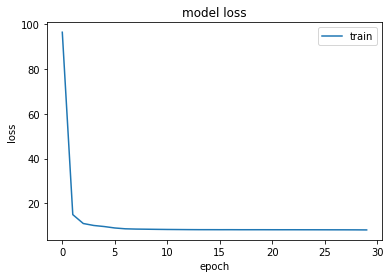

In [ ]:
# loss 그래프로 모델 학습 결과 확인

plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [ ]:
# 예측 및 문턱값 정의

val_2_pred = vae_model.predict(val_2_scaled)

mae_vector = get_error_term(val_2_pred, val_2_scaled, _rmse=False)

print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.023967175061257468
median error 0.022262942353731642
99Q: 0.05918247150812315
setting threshold on 0.05918247150812315 


In [ ]:
# 이상치 정의 및 비율 파악
anomalies = (mae_vector > error_thresh)
y_pred_vae = np.where(anomalies == False, 0, 1)

np.unique(y_pred_vae, return_counts=True)
# np.count_nonzero(anomalies) / len(anomalies)

(array([0, 1]), array([28177,   285]))

In [ ]:
# 평가
# from sklearn.metrics import classification_report, f1_score

# val_score_2 = f1_score(y_val, anomalies, average='macro')

# print(f'Validation F1 Score : [{val_score_2}]')
# print(classification_report(y_val, anomalies))

Validation F1 Score : [0.5738321939385375]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     28432
           1       0.08      0.80      0.15        30

    accuracy                           0.99     28462
   macro avg       0.54      0.90      0.57     28462
weighted avg       1.00      0.99      0.99     28462



### 보팅 모델과 각각 모델 성능 비교

In [ ]:
# 세 모델이 val 데이터로 예측한 레이블을 다 넣어서 데이터프레임화
val_df_X['Class_EE'] = y_pred_EE
val_df_X['Class_IF'] = y_pred_IF
val_df_X['Class_VAE'] = y_pred_vae

val_df_X

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V24,V25,V26,V27,V28,V29,V30,Class_EE,Class_IF,Class_VAE
0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,-0.385050,-0.069733,0.094199,0.246219,0.083076,-0.255991,-0.994878,0,0,0
1,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,0.724396,...,-1.371866,0.390814,0.199964,0.016371,-0.014605,0.168937,-0.994784,0,0,0
2,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,0.757952,...,0.691320,0.633984,0.048741,-0.053192,0.016251,0.169496,-0.994502,0,0,0
3,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.615371,0.226278,-0.225495,...,-0.992569,0.085096,0.377447,0.036096,-0.005960,0.331307,-0.994467,0,0,0
4,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,6.051521,...,0.515821,0.136318,0.460054,-0.251259,-1.105751,-0.287012,-0.994373,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28457,-0.546378,1.433992,-0.313252,0.926044,0.522388,-0.565669,1.066075,0.269799,-1.099446,-0.077753,...,0.030397,0.018381,-0.395994,0.301655,0.173585,0.202753,1.034622,0,0,0
28458,-0.764523,0.588379,-0.907599,-0.418847,0.901528,-0.760802,0.758545,0.414698,-0.730854,-1.245088,...,0.587119,-0.200998,0.267337,-0.152951,-0.065285,0.810452,1.034693,0,0,0
28459,-0.446951,1.302212,-0.168583,0.981577,0.578957,-0.605641,1.253430,-1.042610,-0.417116,0.076605,...,-0.038712,0.010209,-0.362666,0.503092,0.229921,0.537972,1.034763,0,0,0
28460,2.039560,-0.175233,-1.196825,0.234580,-0.008713,-0.726571,0.017050,-0.118228,0.435402,0.267772,...,-0.359769,-0.315610,0.201114,-0.080826,-0.075071,-0.269964,1.034928,0,0,0


In [ ]:
class_voting = []

for i in range(len(val_df_X)) : 
    if val_df_X['Class_EE'][i] + val_df_X['Class_IF'][i] + val_df_X['Class_VAE'][i] == 3:
        class_voting.append(1) 
    else :
        class_voting.append(0)
        
val_df_X['Class_voting'] = class_voting
val_df_X

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V25,V26,V27,V28,V29,V30,Class_EE,Class_IF,Class_VAE,Class_voting
0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,-0.069733,0.094199,0.246219,0.083076,-0.255991,-0.994878,0,0,0,0
1,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,0.724396,...,0.390814,0.199964,0.016371,-0.014605,0.168937,-0.994784,0,0,0,0
2,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,0.757952,...,0.633984,0.048741,-0.053192,0.016251,0.169496,-0.994502,0,0,0,0
3,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.615371,0.226278,-0.225495,...,0.085096,0.377447,0.036096,-0.005960,0.331307,-0.994467,0,0,0,0
4,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,6.051521,...,0.136318,0.460054,-0.251259,-1.105751,-0.287012,-0.994373,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28457,-0.546378,1.433992,-0.313252,0.926044,0.522388,-0.565669,1.066075,0.269799,-1.099446,-0.077753,...,0.018381,-0.395994,0.301655,0.173585,0.202753,1.034622,0,0,0,0
28458,-0.764523,0.588379,-0.907599,-0.418847,0.901528,-0.760802,0.758545,0.414698,-0.730854,-1.245088,...,-0.200998,0.267337,-0.152951,-0.065285,0.810452,1.034693,0,0,0,0
28459,-0.446951,1.302212,-0.168583,0.981577,0.578957,-0.605641,1.253430,-1.042610,-0.417116,0.076605,...,0.010209,-0.362666,0.503092,0.229921,0.537972,1.034763,0,0,0,0
28460,2.039560,-0.175233,-1.196825,0.234580,-0.008713,-0.726571,0.017050,-0.118228,0.435402,0.267772,...,-0.315610,0.201114,-0.080826,-0.075071,-0.269964,1.034928,0,0,0,0


In [ ]:
val_df_X['Class_voting'].value_counts()

0    28446
1       16
Name: Class_voting, dtype: int64

In [ ]:
type(y_val[0])

numpy.int64

In [ ]:
y_pred_vt = np.array(val_df_X['Class_voting'])
y_pred_vt

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import classification_report, f1_score

val_score_vt = f1_score(y_val, y_pred_vt, average='macro')

print(f'Validation F1 Score : [{val_score_vt}]')
print(classification_report(y_val, y_pred_vt))

Validation F1 Score : [0.7389194569001234]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.69      0.37      0.48        30

    accuracy                           1.00     28462
   macro avg       0.84      0.68      0.74     28462
weighted avg       1.00      1.00      1.00     28462



In [ ]:
# 만약 and 가 아닌 or 이었다면?
class_voting_2 = []

for i in range(len(val_df_X)) : 
    if val_df_X['Class_EE'][i] + val_df_X['Class_IF'][i] + val_df_X['Class_VAE'][i] == 0:
        class_voting_2.append(0)
    else :
        class_voting_2.append(1)
        
val_df_X['Class_voting_2'] = class_voting_2
val_df_X

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V26,V27,V28,V29,V30,Class_EE,Class_IF,Class_VAE,Class_voting,Class_voting_2
0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,0.094199,0.246219,0.083076,-0.255991,-0.994878,0,0,0,0,0
1,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,0.724396,...,0.199964,0.016371,-0.014605,0.168937,-0.994784,0,0,0,0,0
2,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,0.757952,...,0.048741,-0.053192,0.016251,0.169496,-0.994502,0,0,0,0,0
3,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.615371,0.226278,-0.225495,...,0.377447,0.036096,-0.005960,0.331307,-0.994467,0,0,0,0,0
4,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,6.051521,...,0.460054,-0.251259,-1.105751,-0.287012,-0.994373,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28457,-0.546378,1.433992,-0.313252,0.926044,0.522388,-0.565669,1.066075,0.269799,-1.099446,-0.077753,...,-0.395994,0.301655,0.173585,0.202753,1.034622,0,0,0,0,0
28458,-0.764523,0.588379,-0.907599,-0.418847,0.901528,-0.760802,0.758545,0.414698,-0.730854,-1.245088,...,0.267337,-0.152951,-0.065285,0.810452,1.034693,0,0,0,0,0
28459,-0.446951,1.302212,-0.168583,0.981577,0.578957,-0.605641,1.253430,-1.042610,-0.417116,0.076605,...,-0.362666,0.503092,0.229921,0.537972,1.034763,0,0,0,0,0
28460,2.039560,-0.175233,-1.196825,0.234580,-0.008713,-0.726571,0.017050,-0.118228,0.435402,0.267772,...,0.201114,-0.080826,-0.075071,-0.269964,1.034928,0,0,0,0,0


In [ ]:
val_df_X['Class_voting_2'].value_counts()

0    28177
1      285
Name: Class_voting_2, dtype: int64

In [ ]:
y_pred_vt_2 = np.array(val_df_X['Class_voting_2'])
y_pred_vt_2

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# from sklearn.metrics import classification_report, f1_score

val_score_vt_2 = f1_score(y_val, y_pred_vt_2, average='macro')

print(f'Validation F1 Score : [{val_score_vt_2}]')
print(classification_report(y_val, y_pred_vt_2))

Validation F1 Score : [0.5770244621487357]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     28432
           1       0.09      0.83      0.16        30

    accuracy                           0.99     28462
   macro avg       0.54      0.91      0.58     28462
weighted avg       1.00      0.99      0.99     28462



In [ ]:
# 다수결이라면?
class_voting_3 = []

for i in range(len(val_df_X)) : 
    if val_df_X['Class_EE'][i] + val_df_X['Class_IF'][i] + val_df_X['Class_VAE'][i] >= 2:
        class_voting_3.append(1)
    else :
        class_voting_3.append(0)
        
val_df_X['Class_voting_3'] = class_voting_3
val_df_X

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V27,V28,V29,V30,Class_EE,Class_IF,Class_VAE,Class_voting,Class_voting_2,Class_voting_3
0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,0.246219,0.083076,-0.255991,-0.994878,0,0,0,0,0,0
1,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,0.724396,...,0.016371,-0.014605,0.168937,-0.994784,0,0,0,0,0,0
2,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,0.757952,...,-0.053192,0.016251,0.169496,-0.994502,0,0,0,0,0,0
3,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.615371,0.226278,-0.225495,...,0.036096,-0.005960,0.331307,-0.994467,0,0,0,0,0,0
4,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,6.051521,...,-0.251259,-1.105751,-0.287012,-0.994373,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28457,-0.546378,1.433992,-0.313252,0.926044,0.522388,-0.565669,1.066075,0.269799,-1.099446,-0.077753,...,0.301655,0.173585,0.202753,1.034622,0,0,0,0,0,0
28458,-0.764523,0.588379,-0.907599,-0.418847,0.901528,-0.760802,0.758545,0.414698,-0.730854,-1.245088,...,-0.152951,-0.065285,0.810452,1.034693,0,0,0,0,0,0
28459,-0.446951,1.302212,-0.168583,0.981577,0.578957,-0.605641,1.253430,-1.042610,-0.417116,0.076605,...,0.503092,0.229921,0.537972,1.034763,0,0,0,0,0,0
28460,2.039560,-0.175233,-1.196825,0.234580,-0.008713,-0.726571,0.017050,-0.118228,0.435402,0.267772,...,-0.080826,-0.075071,-0.269964,1.034928,0,0,0,0,0,0


In [ ]:
val_df_X['Class_voting_3'].value_counts()

0    28411
1       51
Name: Class_voting_3, dtype: int64

In [ ]:
y_pred_vt_3 = np.array(val_df_X['Class_voting_3'])

In [ ]:
# from sklearn.metrics import classification_report, f1_score

val_score_vt_3 = f1_score(y_val, y_pred_vt_3, average='macro')

print(f'Validation F1 Score : [{val_score_vt_3}]')
print(classification_report(y_val, y_pred_vt_3))

Validation F1 Score : [0.6970998524634563]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.31      0.53      0.40        30

    accuracy                           1.00     28462
   macro avg       0.66      0.77      0.70     28462
weighted avg       1.00      1.00      1.00     28462

